# Programming on GPUs

The goal of this notebook is to learn the basics of programming on GPUs. We start with [Numba](https://numba.pydata.org/) a just-in-time compiler for Python and then move on to [Triton](https://openai.com/index/triton/) an open-source Python-like programming language developed by OpenAI.

You will probably need to learn a lot of new concepts but this notebook will ask you to code in an interactive way with minimal presentation of the core concepts. If you are stuck ask for help to your favorite chat without asking for the exact solution.

Sources: Nvidia [CUDA documentation](https://docs.nvidia.com/cuda/cuda-programming-guide/01-introduction/programming-model.html) and [GPU-Puzzles](https://github.com/srush/GPU-Puzzles)

In [1]:
import numba
import numpy as np
from numba import cuda

In [2]:
import warnings
warnings.filterwarnings(
    action="ignore", category=numba.NumbaPerformanceWarning, module="numba"
)

## Main Concepts

- **Streaming Multiprocessor (SM)** GPU's unit of computation 
- **Thread** smallest unit of execution
- **Block or Thread Block** a group of threads guaranteed to run on a single SM 
- **Grid** Thread blocks are organized into a grid
- **Warp** Within a thread block, threads are organized into groups of 32 threads called warps. A warp executes the kernel code in a Single-Instruction Multiple-Threads (SIMT) paradigm. In SIMT, all threads in the warp are executing the same kernel code.

Let's start! 

In [3]:
def map_spec(a):
    return a + 10

# Size of our array
SIZE = 4

# Create input and output arrays
a = np.arange(SIZE, dtype=np.float32)  # [0, 1, 2, 3]
out = np.zeros(SIZE, dtype=np.float32)

map_spec(a)

array([10., 11., 12., 13.], dtype=float32)

Now we want to code this so that each thread adds 10 to one element of the array using Numba.

In [4]:
# Define the CUDA kernel
@cuda.jit
def map_kernel(out, a):
    # Get the thread index
    i = cuda.threadIdx.x
    # Each thread adds 10 to one element
    # your code here
    out[i] = a[i] + 10


# Copy arrays to GPU
a_device = cuda.to_device(a)
out_device = cuda.to_device(out)

# kernel[grid, block](args)
# Launch kernel: grid = 1 block, block = SIZE threads
map_kernel[1, SIZE](out_device, a_device)

# Copy result back to CPU
result = out_device.copy_to_host()

# Verify result
expected = map_spec(a)
print(f"Input:    {a}")
print(f"Output:   {result}")
print(f"Expected: {expected}")
print(f"Correct:  {np.allclose(result, expected)}")

Input:    [0. 1. 2. 3.]
Output:   [10. 11. 12. 13.]
Expected: [10. 11. 12. 13.]
Correct:  True


Let's move to vector addition!

In [5]:
def zip_spec(a, b):
    return a + b

out = np.zeros(SIZE)
a = np.arange(SIZE)
b = np.arange(SIZE)
zip_spec(a,b)

array([0, 2, 4, 6])

In [6]:
# Define the CUDA kernel
@cuda.jit
def zip_kernel(out, a, b):
    # Get the thread index
    i = cuda.threadIdx.x
    # your code here
    out[i] = a[i] + b[i]

# A function to move vectors on device
def init_pb(a=a, b=b, out=out):
    a_device = cuda.to_device(a)
    b_device = cuda.to_device(b)
    out_device = cuda.to_device(out)
    return a_device, b_device, out_device

a_device, b_device, out_device = init_pb()

# Launch kernel: 1 block, SIZE threads
zip_kernel[1, SIZE](out_device, a_device, b_device)

# Copy result back to CPU
result = out_device.copy_to_host()

# Verify result
expected = zip_spec(a, b)
print(f"Input a:  {a}")
print(f"Input b:  {b}")
print(f"Output:   {result}")
print(f"Expected: {expected}")
print(f"Correct:  {np.allclose(result, expected)}")

Input a:  [0 1 2 3]
Input b:  [0 1 2 3]
Output:   [0. 2. 4. 6.]
Expected: [0 2 4 6]
Correct:  True


What happens if you increase the number of threads?

In [7]:
a_device, b_device, out_device = init_pb()

NUM_TRHEADS = 2*SIZE
zip_kernel[1, NUM_TRHEADS](out_device, a_device, b_device)

# Copy result back to CPU
result = out_device.copy_to_host()

# Verify result
expected = zip_spec(a, b)
print(f"Output:   {result}")
print(f"Expected: {expected}")
print(f"Correct:  {np.allclose(result, expected)}")

Output:   [0. 2. 4. 6.]
Expected: [0 2 4 6]
Correct:  True


Still working but unsafe (due to out-of-bounds access). Add a guard clause to prevent out-of-bounds access.

In [8]:
# CUDA kernel with Guard
@cuda.jit
def zip_guard_kernel(out, a, b, size):
    # Get the thread index
    i = cuda.threadIdx.x
    # your code here
    if i < size:
        out[i] = a[i] + b[i]

a_device, b_device, out_device = init_pb()

NUM_TRHEADS = 2*SIZE
zip_guard_kernel[1, NUM_TRHEADS](out_device, a_device, b_device, SIZE)

# Copy result back to CPU
result = out_device.copy_to_host()

# Verify result
expected = zip_spec(a, b)
print(f"Output:   {result}")
print(f"Expected: {expected}")
print(f"Correct:  {np.allclose(result, expected)}")

Output:   [0. 2. 4. 6.]
Expected: [0 2 4 6]
Correct:  True


Let's move to matrices now!

In [9]:
a = np.arange(SIZE * SIZE).reshape((SIZE, SIZE))
out = map_spec(a)
out

array([[10, 11, 12, 13],
       [14, 15, 16, 17],
       [18, 19, 20, 21],
       [22, 23, 24, 25]])

So far, we used 1-D **Thread Block** but **Thread Blocks** can be organized in 2-D or 3-D. These dimensions can simplify mapping of individual threads to units of work or data items.
Below, you need to use a 2-D **Thread Block**:

In [10]:
@cuda.jit
def map_2d_kernel(out, a, size):
    i = cuda.threadIdx.x
    j = cuda.threadIdx.y
    # your code here
    if i < size and j < size:
        out[i,j] = a[i,j] + 10

a_device, b_device, out_device = init_pb(a=a, out=np.zeros_like(out))

TRHEAD_BLOCK = (SIZE, SIZE)
map_2d_kernel[1, TRHEAD_BLOCK](out_device, a_device, SIZE)

result = out_device.copy_to_host()

# Verify result
expected = map_spec(a)
print(f"Output:   {result}")
print(f"Expected: {expected}")
print(f"Correct:  {np.allclose(result, expected)}")

Output:   [[10 11 12 13]
 [14 15 16 17]
 [18 19 20 21]
 [22 23 24 25]]
Expected: [[10 11 12 13]
 [14 15 16 17]
 [18 19 20 21]
 [22 23 24 25]]
Correct:  True


Broadcasting:

In [11]:
a = np.arange(SIZE).reshape(SIZE, 1)
b = np.arange(SIZE).reshape(1, SIZE)
out = a + b
out

array([[0, 1, 2, 3],
       [1, 2, 3, 4],
       [2, 3, 4, 5],
       [3, 4, 5, 6]])

In [12]:
@cuda.jit
def broadcast_kernel(out, a, b, size):
    i = cuda.threadIdx.x
    j = cuda.threadIdx.y
    #your code here
    if i < size and j < size:
        out[i,j] = a[i,0] + b[0,j]

a_device, b_device, out_device = init_pb(a=a, b=b, out=np.zeros_like(out))

THREAD_BLOCK = (2*SIZE, 3*SIZE)
broadcast_kernel[1, THREAD_BLOCK](out_device, a_device, b_device, SIZE)

result = out_device.copy_to_host()

# Verify result
expected = a + b
print(f"Output:   {result}")
print(f"Expected: {expected}")
print(f"Correct:  {np.allclose(result, expected)}")

Output:   [[0 1 2 3]
 [1 2 3 4]
 [2 3 4 5]
 [3 4 5 6]]
Expected: [[0 1 2 3]
 [1 2 3 4]
 [2 3 4 5]
 [3 4 5 6]]
Correct:  True


So far, we did not use **grid** but like **Thread Block**, grids may be 1, 2, or 3 dimensional. Below use a 2D grid with a single thread per block!

In [13]:
@cuda.jit
def broadcast_grid_kernel(out, a, b, size):
    i = cuda.blockIdx.x 
    j = cuda.blockIdx.y
    # your code here
    if i < size and j < size:
        out[i,j] = a[i,0] + b[0,j]

a_device, b_device, out_device = init_pb(a=a, b=b, out=np.zeros_like(out))

# 1 thread per block, 2D grid
THREADS = 1
GRID = (SIZE, SIZE)
broadcast_grid_kernel[GRID, THREADS](out_device, a_device, b_device, SIZE)

result = out_device.copy_to_host()

# Verify result
expected = a + b
print(f"Output:   {result}")
print(f"Expected: {expected}")
print(f"Correct:  {np.allclose(result, expected)}")

Output:   [[0 1 2 3]
 [1 2 3 4]
 [2 3 4 5]
 [3 4 5 6]]
Expected: [[0 1 2 3]
 [1 2 3 4]
 [2 3 4 5]
 [3 4 5 6]]
Correct:  True


Below, you need to use a 1D grid with a 1D Thread block.

In [14]:
@cuda.jit
def broadcast_grid_kernel(out, a, b, size):
    # your code here
    i = cuda.threadIdx.x
    j = cuda.blockIdx.y
    if i < size and j < size:
        out[i,j] = a[i,0] + b[0,j]

a_device, b_device, out_device = init_pb(a=a, b=b, out=np.zeros_like(out))

THREADS = SIZE
GRID = SIZE
broadcast_grid_kernel[GRID, THREADS](out_device, a_device, b_device, SIZE)

result = out_device.copy_to_host()

# Verify result
expected = a + b
print(f"Output:   {result}")
print(f"Expected: {expected}")
print(f"Correct:  {np.allclose(result, expected)}")

Output:   [[0 0 0 0]
 [1 0 0 0]
 [2 0 0 0]
 [3 0 0 0]]
Expected: [[0 1 2 3]
 [1 2 3 4]
 [2 3 4 5]
 [3 4 5 6]]
Correct:  False


And now, use small 2D grid and blocks.
Here we have `cuda.blockDim.x = cuda.blockDim.y =2 ` and sinc `SIZE//2 = 2`, you need to compute i,j as below:

| blockIdx.x | blockIdx.y  | threadIdx.x | threadIdx.y | **i** | **j** | Computes |
|------------|---------------|-------------|-------------|-------|-------|----------|
| 0 | 0 | 0 | 0 | **0** | **0** | out[0,0] |
| 0 | 0 | 1 | 0 | **1** | **0** | out[1,0] |
| 0 | 0 | 0 | 1 | **0** | **1** | out[0,1] |
| 0 | 0 | 1 | 1 | **1** | **1** | out[1,1] |
| 1 | 0 | 0 | 0 | **2** | **0** | out[2,0] |
| 1 | 0 | 1 | 0 | **3** | **0** | out[3,0] |
| 0 | 1 | 0 | 0 | **0** | **2** | out[0,2] |
| 0 | 1 | 1 | 1 | **1** | **3** | out[1,3] |
| 1 | 1 | 0 | 0 | **2** | **2** | out[2,2] |
| 1 | 1 | 1 | 1 | **3** | **3** | out[3,3] |

In [15]:
@cuda.jit
def broadcast_grid_kernel(out, a, b, size):
    # your code here
    i = cuda.blockIdx.x*cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y*cuda.blockDim.y + cuda.threadIdx.y
    if i < size and j < size:
        out[i,j] = a[i,0] + b[0,j]

a_device, b_device, out_device = init_pb(a=a, b=b, out=np.zeros_like(out))

THREADS = (SIZE//2 , SIZE//2)
GRID = (SIZE//2, SIZE//2)  
broadcast_grid_kernel[GRID, THREADS](out_device, a_device, b_device, SIZE)

result = out_device.copy_to_host()

# Verify result
expected = a + b
print(f"Output:   {result}")
print(f"Expected: {expected}")
print(f"Correct:  {np.allclose(result, expected)}")

Output:   [[0 1 2 3]
 [1 2 3 4]
 [2 3 4 5]
 [3 4 5 6]]
Expected: [[0 1 2 3]
 [1 2 3 4]
 [2 3 4 5]
 [3 4 5 6]]
Correct:  True


## Memory

<div>
<img src="https://docs.nvidia.com/cuda/cuda-programming-guide/_images/gpu-cpu-system-diagram.png" width="700"/>
</div>

- **Dynamic random-access memory DRAM** DRAM attached to the GPU is called **global memory**, because it is accessible to all SMs in the GPU. The DRAM attached to the CPU(s) is called system memory or host memory.
- On-Chip Memory in GPUs: **Shared Memory** and **Registers**. Programmers use this shared memory as a manually managed cache. Threads have access to private **registers**.

In [16]:
def pool_spec(a):
    out = np.zeros(a.shape)
    for i in range(a.shape[0]):
        out[i] = a[max(i - 2, 0) : i + 1].sum()
    return out

SIZE = 8
a = np.arange(SIZE)
out = pool_spec(a)
out

array([ 0.,  1.,  3.,  6.,  9., 12., 15., 18.])

In [17]:
@cuda.jit
def pool_kernel(out, a, size):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if i < size:
        # Manually compute sum - can't use slicing in CUDA!
        temp_sum = 0.0
        for k in range(max(i - 2, 0), i + 1):
            temp_sum += a[k]  # Use global memory
        out[i] = temp_sum

a_device, b_device, out_device = init_pb(a=a, out=np.zeros_like(out))

THREADS = SIZE//2
GRID = (2,1)  
pool_kernel[GRID, THREADS](out_device, a_device, SIZE)

result = out_device.copy_to_host()

# Verify result
expected = pool_spec(a)
print(f"Output:   {result}")
print(f"Expected: {expected}")
print(f"Correct:  {np.allclose(result, expected)}")
r = 3
print(f"number of access to global memory: 1 + 2 + {THREADS-2} threads x {r} reads = {1+2+(THREADS-2)*r} global reads per block -> {2*(1+2+(THREADS-2)*r)} global reads in total")

Output:   [ 0.  1.  3.  6.  9. 12. 15. 18.]
Expected: [ 0.  1.  3.  6.  9. 12. 15. 18.]
Correct:  True
number of access to global memory: 1 + 2 + 2 threads x 3 reads = 9 global reads per block -> 18 global reads in total


So now, we want to get a lower number of access to global memory by using shared memory.

```
Memory hierarchy:
┌─────────────────────────────────────┐
│  Global Memory (a, out)             │  ← ALL threads can access
│  - Slow                             │
│  - Accessible across all blocks     │
└─────────────────────────────────────┘
         ↓                    ↓
   ┌─────────┐          ┌─────────┐
   │ Block 0 │          │ Block 1 │
   │ Shared  │          │ Shared  │      ← Only threads in THIS block
   │ Memory  │          │ Memory  │         can access
   │ (fast)  │          │ (fast)  │
   └─────────┘          └─────────┘
```
The method below allows for 8+4=12 global reads in total.

**How it works:**
```
Global:      [0, 1, 2, 3, 4, 5, 6, 7]
Block 0 loads:              Block 1 loads:
        ↓                          ↓
Shared: [0, 0, 0, 1, 2, 3] Shared: [2, 3, 4, 5, 6, 7]
         └─┘  └──────────┘         └──┘  └──────────┘
        halo    main data          halo    main data
```

Each block can only have a constant amount of shared memory that threads in that block can read and write to. This needs to be a literal python constant not a variable. After writing to shared memory you need to call `cuda.syncthreads` to ensure that threads do not cross.

In [22]:
TPB = 4  # Threads per block
SharedMem = TPB + 2 # cannot be computed at runtime
@cuda.jit
def pool_kernel_shared(out, a, size):
    # Allocate shared memory with HALO (extra elements for boundary)
    # Need TPB + 2 extra elements (for the 2-element lookback)
    shared = cuda.shared.array(SharedMem, numba.float32)
    
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    local_i = cuda.threadIdx.x
    
    # Each thread loads its own element into shared memory (offset by 2 for halo)
    if i < size:
        shared[local_i + 2] = a[i]
    
    # First 2 threads also load the HALO (left boundary elements)
    if local_i == 0:
        # Load 2 elements before the block starts
        start_idx = cuda.blockIdx.x * cuda.blockDim.x
        if start_idx >= 2:
            shared[1] = a[start_idx - 1]
            shared[0] = a[start_idx - 2]
        else:
            shared[1] = 0.0
            shared[0] = 0.0 # Padding for out-of-bounds
            
    # Wait for all threads to finish loading
    cuda.syncthreads()
    
    # Now compute using shared memory
    if i < size:
        temp_sum = 0.0
        # Look back up to 2 elements in shared memory
        for k in range(max(0, 3 - (i + 1)), 3):  # At most 3 elements
            temp_sum += shared[local_i + 2 - (2 - k)]
        out[i] = temp_sum

a_device, b_device, out_device = init_pb(a=a, out=np.zeros_like(out))


GRID = (SIZE // TPB, 1)  # (2, 1) for SIZE=8, TPB=4
pool_kernel_shared[GRID, TPB](out_device, a_device, SIZE)

result = out_device.copy_to_host()

expected = pool_spec(a)
print(f"Output:   {result}")
print(f"Expected: {expected}")
print(f"Correct:  {np.allclose(result, expected)}")

Output:   [ 0.  1.  3.  6.  9. 12. 15. 18.]
Expected: [ 0.  1.  3.  6.  9. 12. 15. 18.]
Correct:  True


Now, we need to implement the dot product. Serially, the code is trivial:

In [24]:
def dot_spec(a,b):
    tot = 0
    for i in range(len(a)):
        tot += a[i]*b[i]
    return tot

SIZE = 8
a = np.arange(SIZE, dtype=np.float32)
b = np.arange(SIZE, dtype=np.float32)
dot_spec(a,b)

np.float32(140.0)

In parallel, the problem is a lot harder. Here is a a tree-based summation algorithm:

![](https://www.cs.uaf.edu/2012/fall/cs441/lecture/tree_sum_16td.png)

In [35]:
def dot_tree(a,b):
    size = len(a)
    shared_mem = np.zeros(size)
    for i in range(size):
       shared_mem[i] = a[i]*b[i]
    stride = size // 2
    while stride > 0:
        for i in range(stride):
            shared_mem[i] += shared_mem[i+stride]
        stride //=2
    return shared_mem[0]
dot_tree(a,b)       

np.float64(108611072.0)

Now you need to code this algorithm in numba. You have 256 threads per block and sufficient blocks to have more threads than the size of your input vectors `a` and `b`.

In [36]:
SIZE = 800
a = np.arange(SIZE, dtype=np.float32)
b = np.arange(SIZE, dtype=np.float32)

threads_per_block = 256
blocks_per_grid = (SIZE + threads_per_block - 1) // threads_per_block
print(f"threads per block: {threads_per_block}")
print(f"blocks per grid: {blocks_per_grid}")

threads per block: 256
blocks per grid: 4


For each block, you can implement the tree-based summation algorithm by first creating a shared memory of size 256 containing the `a[i]*b[i]` with the `i` associated witht the block thread. Then suming it accross the block. The last step consists in adding all the intermediate results: each block adds its result. For this last step, you might want to use `cuda.atomic.add` see below:

### The Problem Without Atomics
When you write out[0] = out[0] + value, it's actually 3 separate steps:
```
# out[0] = out[0] + value breaks down to:
1. READ:   temp = out[0]      # Read current value
2. MODIFY: temp = temp + value # Add to it
3. WRITE:  out[0] = temp       # Write back
```

**With multiple threads, these steps can interleave and lose updates:**
```
Initial: out[0] = 0

Thread A (Block 0):              Thread B (Block 1):
1. READ: temp_A = 0             
2. MODIFY: temp_A = 0 + 5       
                                 1. READ: temp_B = 0      ← Still sees 0!
3. WRITE: out[0] = 5            
                                 2. MODIFY: temp_B = 0 + 3 ← Uses old value!
                                 3. WRITE: out[0] = 3      ← Overwrites 5!

Final: out[0] = 3  ❌ Should be 8!
```

### What Atomics Do

`cuda.atomic.add(out, 0, value)` **locks the memory location** so the entire operation completes before another thread can access it:
```
Initial: out[0] = 0

Thread A (Block 0):              Thread B (Block 1):
🔒 LOCK out[0]
1. READ: temp_A = 0             
2. MODIFY: temp_A = 0 + 5       
3. WRITE: out[0] = 5            
🔓 UNLOCK out[0]
                                 🔒 LOCK out[0]  ← Must wait for unlock
                                 1. READ: temp_B = 5      ← Sees updated value!
                                 2. MODIFY: temp_B = 5 + 3
                                 3. WRITE: out[0] = 8
                                 🔓 UNLOCK out[0]

Final: out[0] = 8  ✅ Correct!
```

In [46]:
@cuda.jit
def dot_kernel_numba(a, b, out, size):
    shared = cuda.shared.array(256, numba.float32)
    # your code here
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    local_i = cuda.threadIdx.x
    
    if i < size:
        shared[local_i] = a[i] * b[i]
    else:
        shared[local_i] = 0.0
    cuda.syncthreads()
    
    stride = cuda.blockDim.x // 2
    while stride > 0:
        if local_i < stride:
            shared[local_i] += shared[local_i + stride]
        cuda.syncthreads()
        stride //= 2
    
    if local_i == 0:
        cuda.atomic.add(out, 0, shared[0]) # To avoid RACE CONDITION! Multiple blocks write to out[0] see below


a_device, b_device, out_device = init_pb(a=a, b=b, out=np.zeros_like([expected]))

size = a_device.shape[0]
dot_kernel_numba[blocks_per_grid, threads_per_block](a_device, b_device, out_device, size)

result = out_device.copy_to_host()
expected = np.dot(a, b)
print(f"CUDA result: {result[0]}")
print(f"NumPy result: {expected}")
print(f"Match: {np.allclose(result[0], expected)}")

CUDA result: 170346800.0
NumPy result: 170346800.0
Match: True


## Numba: Grid and Block Dimensions

**Key concepts:**
- `kernel[grid, block](args)` - Launch syntax
- **Grid** = `(blocks_x, blocks_y, blocks_z)` - How many blocks
- **Block** = `(threads_x, threads_y, threads_z)` - How many threads per block
- Total threads = `grid_x × grid_y × grid_z × block_x × block_y × block_z`

---

## Triton: Program Grid

In **Triton**, you specify a **program grid** and work with **program IDs**.

**Key concepts:**
- `kernel[grid](args, BLOCK_SIZE=...)` - Launch syntax
- **Grid** = `(programs_x, programs_y, programs_z)` - Number of program instances
- **No explicit block/thread dimensions** - Triton handles threading automatically
- Work with **blocks of data** using `tl.arange()` and vectorized operations

---

## Comparison Table

| Aspect | Numba CUDA | Triton |
|--------|------------|--------|
| **Launch syntax** | `kernel[grid, block](args)` | `kernel[grid](args, BLOCK=...)` |
| **Grid represents** | Number of **blocks** | Number of **programs** |
| **Block/Thread control** | Explicit: `(tx, ty, tz)` per block | Abstracted: work on data blocks |
| **Thread indexing** | Manual: `blockIdx`, `threadIdx` | Automatic: `tl.program_id()` + `tl.arange()` |
| **Typical grid** | `(n_blocks_x, n_blocks_y, n_blocks_z)` | `(n_programs_x, n_programs_y, n_programs_z)` |
| **Typical block** | `(threads_x, threads_y, threads_z)` | N/A (implicit in `BLOCK_SIZE`) |
| **Memory access** | Per-thread indexing | Vectorized block operations |
| **Abstraction level** | Low-level (like CUDA C) | High-level (compiler optimizes) |

---

## Key Takeaway

- **Numba CUDA**: You think in terms of **blocks of threads** (2-level hierarchy: grid → blocks → threads)
- **Triton**: You think in terms of **programs operating on data blocks** (1-level: grid → programs, with implicit vectorization)

Triton is conceptually **one level of "blocks"** in CUDA terms - each Triton program is roughly equivalent to a CUDA block, but Triton automatically handles the thread-level parallelism within that program.

## Practical Example: Vector Addition

Below is the solution of a puzzle above:

In [57]:
# CUDA kernel with Guard
@cuda.jit
def zip_guard_kernel(out, a, b, size):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if i < size:
        out[i] = a[i] + b[i]

SIZE = 1000
out = np.zeros(SIZE)
a = np.arange(SIZE)
b = np.arange(SIZE)

a_device, b_device, out_device = init_pb(a=a, b=b, out=out)

threads_per_block = 256
blocks_per_grid = (SIZE + threads_per_block - 1) // threads_per_block
zip_guard_kernel[blocks_per_grid, threads_per_block](out_device, a_device, b_device, SIZE)

# Copy result back to CPU
result = out_device.copy_to_host()

# Verify result
expected = zip_spec(a, b)
print(f"Correct:  {np.allclose(result, expected)}")

Correct:  True


In [113]:
import triton
import triton.language as tl
import torch
from einops import rearrange

def get_device(index: int = 0) -> torch.device:
    """Try to use the GPU if possible, otherwise, use CPU."""
    if torch.cuda.is_available():
        return torch.device(f"cuda:{index}")
    else:
        return torch.device("cpu")

In [69]:
@triton.jit
def zip_guard_triton(a_ptr, b_ptr, out_ptr, n, BLOCK_SIZE: tl.constexpr):
    # Triton uses program_id (block index) instead of explicit blockIdx/threadIdx
    # Each "program" processes BLOCK_SIZE elements at once (vectorized)
    pid = tl.program_id(0)
    
    # Triton computes offsets for a *vector* of BLOCK_SIZE elements
    # Unlike Numba where each thread processes 1 element,
    # Triton processes multiple elements per program instance
    offset = pid * BLOCK_SIZE + tl.arange(0, BLOCK_SIZE)
    
    # Triton uses mask-based guards for vectorized operations
    # instead of scalar if-statements (if i < size)
    mask = offset < n
    
    # Vectorized load: loads BLOCK_SIZE elements at once with mask
    # Numba loads scalar: a[i]
    a = tl.load(a_ptr + offset, mask=mask)
    b = tl.load(b_ptr + offset, mask=mask)
    
    # Vectorized computation (same as Numba but on vectors)
    c = a + b
    
    # Vectorized store with mask (vs. scalar store in Numba)
    tl.store(out_ptr + offset, c, mask=mask)


# Triton works directly with PyTorch tensors (no manual copy_to_host)
# Numba requires explicit device memory management (init_pb, copy_to_host)
a = torch.randn(SIZE, device=get_device())
b = torch.randn(SIZE, device=get_device())
out = torch.empty_like(a)


# Launch syntax differences:
# - BLOCK_SIZE is a compile-time constant (tl.constexpr) for optimization
# - Only need to specify grid dimensions (not threads_per_block)
# - Triton auto-vectorizes within each program
BLOCK_SIZE = 256
grid = (triton.cdiv(SIZE, BLOCK_SIZE),)  # Only grid size, not block size
zip_guard_triton[grid](a, b, out, SIZE, BLOCK_SIZE=BLOCK_SIZE)

expected = zip_spec(a, b)
print(f"Correct:  {np.allclose(out.cpu().numpy(), expected.cpu().numpy())}")

Correct:  True


Now you need to code the dot product with triton. You can use [`tl.sum` ](https://triton-lang.org/main/python-api/generated/triton.language.sum.html) and [`tl.atomic_add`](https://triton-lang.org/main/python-api/generated/triton.language.atomic_add.html#triton.language.atomic_add)

In [114]:
@triton.jit
def dot_kernel(
    a_ptr,      # Pointer to first input vector
    b_ptr,      # Pointer to second input vector  
    out_ptr,    # Pointer to output scalar
    size,       # Size of vectors
    BLOCK_SIZE: tl.constexpr,  # Elements per program
):
    # Program ID (analogous to blockIdx.x)
    pid = tl.program_id(0)
    
    # Compute offsets for this program's block
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    
    # Mask for boundary handling
    mask = offsets < size
    
    # Load data 
    a = tl.load(a_ptr + offsets, mask=mask)
    b = tl.load(b_ptr + offsets, mask=mask)
    
    # Element-wise multiplication
    products = a * b
    
    # Reduce sum within this block (automatic parallel reduction!)
    block_sum = tl.sum(products)
    
    # Atomic add to output (single thread per block does this)
    tl.atomic_add(out_ptr, block_sum)


def dot_triton(a, b):
    """Wrapper function to launch the kernel"""
    # Allocate output
    out = torch.zeros(1, device=a.device, dtype=a.dtype)
    
    # Grid and block configuration
    size = a.shape[0]
    BLOCK_SIZE = 256  
    grid = (triton.cdiv(size, BLOCK_SIZE),)
    
    # Launch kernel
    dot_kernel[grid](a, b, out, size, BLOCK_SIZE=BLOCK_SIZE)
    
    return out


# Usage example
SIZE = 10
a = torch.arange(SIZE, dtype=torch.float32, device=get_device())
b = torch.arange(SIZE, dtype=torch.float32, device=get_device())

result_triton = dot_triton(a, b)
result_torch = torch.dot(a, b)

print(f"Triton result: {result_triton.item()}")
print(f"PyTorch result: {result_torch.item()}")
print(f"Match: {torch.allclose(result_triton, result_torch)}")

Triton result: 285.0
PyTorch result: 285.0
Match: True


Now, you need to code the softmax function for a batch of vectors z of size `bs x d` we want to compute `torch.softmax(z, axis=1)`.
**Visual:**
```
Memory: [a, b, c, d, e, f, g, h, i, j, k, l]
Shape (3, 4), stride (4, 1):
  [[a, b, c, d],    ← skip 1 for next col, skip 4 for next row
   [e, f, g, h],
   [i, j, k, l]]
```
Example:

In [115]:
# Contiguous 2D tensor (3×4)
x = torch.randn(3, 4)
x.stride()  # (4, 1)
# - Move to next row: skip 4 elements
# - Move to next column: skip 1 element

(4, 1)

In [116]:
# Transposed (now 4×3)
y = x.t()
y.stride()  # (1, 4)
# - Move to next row: skip 1 element (was column)
# - Move to next column: skip 4 elements (was row)
# Note: y shares memory with x, just different access pattern

(1, 4)

**Why it matters:**
For our softmax function, we assume that each program can process one full row independently. The first task will be to locate the start of the corresponding row in memory...

In [117]:
@triton.jit
def triton_softmax_kernel(x_ptr, y_ptr, x_row_stride, y_row_stride, num_cols, BLOCK_SIZE: tl.constexpr):
    assert num_cols <= BLOCK_SIZE
    # Process each row independently
    row_idx = tl.program_id(0)
    col_offsets = tl.arange(0, BLOCK_SIZE)
    # Read from global memory
    x_start_ptr = x_ptr + row_idx * x_row_stride
    x_ptrs = x_start_ptr + col_offsets
    x_row = tl.load(x_ptrs, mask=col_offsets < num_cols, other=float("-inf"))
    # Compute
    x_row = x_row - tl.max(x_row, axis=0)
    numerator = tl.exp(x_row)
    denominator = tl.sum(numerator, axis=0)
    y_row = numerator / denominator
    # Write back to global memory
    y_start_ptr = y_ptr + row_idx * y_row_stride
    y_ptrs = y_start_ptr + col_offsets
    tl.store(y_ptrs, y_row, mask=col_offsets < num_cols)

def triton_softmax(x: torch.Tensor):
    x = x.contiguous()
    # Allocate output tensor
    y = torch.empty_like(x)
    # Determine grid
    M, N = x.shape                          # Number of rows x number of columns
    block_size = triton.next_power_of_2(N)  # Each block contains all the columns
    num_blocks = M                          # Each block is a row
    # Launch kernel
    triton_softmax_kernel[(M,)](
        x_ptr=x, y_ptr=y,
        x_row_stride=x.stride(0), y_row_stride=y.stride(0),
        num_cols=N, BLOCK_SIZE=block_size
    )
    return y

In [118]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=get_device())
y_triton = triton_softmax(x)
y_torch = torch.softmax(x, axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

In [119]:
y_triton = triton_softmax(x.t())
y_torch = torch.softmax(x.t(), axis=1)
assert torch.allclose(y_triton, y_torch), (y_triton, y_torch)

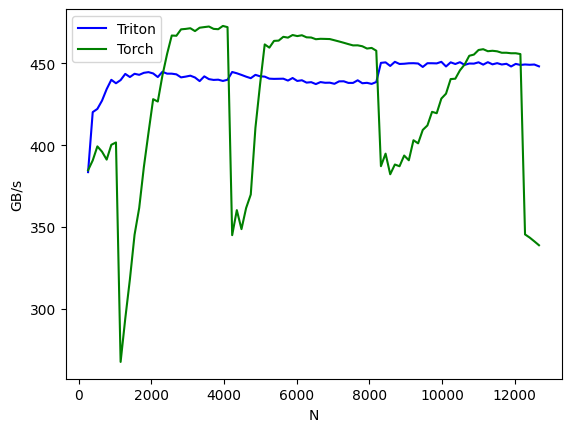

In [120]:
DEVICE = get_device()

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=["Triton", "Torch"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))

def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: triton_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=False)

In [121]:
def weighted_sum(x, weight):
    # Here, assume that x has n-dim shape [..., D], and weight has 1D shape [D]
    return (weight * x).sum(axis=-1)



@triton.jit
def weighted_sum_fwd(
    x_ptr, weight_ptr,  # Input pointers
    output_ptr,  # Output pointer
    x_stride_row, x_stride_dim,  # Strides tell us how to move one element in each axis of a tensor
    weight_stride_dim,  # Likely 1
    output_stride_row,  # Likely 1
    ROWS, D,
    ROWS_TILE_SIZE: tl.constexpr, D_TILE_SIZE: tl.constexpr,  # Tile shapes must be known at compile time
):
    # Each instance will compute the weighted sum of a tile of rows of x.
    # `tl.program_id` gives us a way to check which thread block we're running in
    row_tile_idx = tl.program_id(0)
    
    # Block pointers give us a way to select from an ND region of memory
    # and move our selection around.
    # The block pointer must know:
    # - The pointer to the first element of the tensor
    # - The overall shape of the tensor to handle out-of-bounds access
    # - The strides of each dimension to use the memory layout properly
    # - The ND coordinates of the starting block, i.e., "offsets"
    # - The block shape to use load/store at a time
    # - The order of the dimensions in memory from major to minor
    # axes (= np.argsort(strides)) for optimizations, especially useful on H100
    
    x_block_ptr = tl.make_block_ptr(
        x_ptr,
        shape=(ROWS, D),
        strides=(x_stride_row, x_stride_dim),
        offsets=(row_tile_idx * ROWS_TILE_SIZE, 0),
        block_shape=(ROWS_TILE_SIZE, D_TILE_SIZE),
        order=(1, 0),
    )
    
    weight_block_ptr = tl.make_block_ptr(
        weight_ptr,
        shape=(D,),
        strides=(weight_stride_dim,),
        offsets=(0,),
        block_shape=(D_TILE_SIZE,),
        order=(0,),
    )
    
    output_block_ptr = tl.make_block_ptr(
        output_ptr,
        shape=(ROWS,),
        strides=(output_stride_row,),
        offsets=(row_tile_idx * ROWS_TILE_SIZE,),
        block_shape=(ROWS_TILE_SIZE,),
        order=(0,),
    )
    
    # Initialize a buffer to write to
    output = tl.zeros((ROWS_TILE_SIZE,), dtype=tl.float32)
    
    for i in range(tl.cdiv(D, D_TILE_SIZE)):
        # Load the current block pointer
        # Since ROWS_TILE_SIZE might not divide ROWS, and D_TILE_SIZE might not divide D,
        # we need boundary checks for both dimensions
        row = tl.load(x_block_ptr, boundary_check=(0, 1), padding_option="zero")  # (ROWS_TILE_SIZE, D_TILE_SIZE)
        weight = tl.load(weight_block_ptr, boundary_check=(0,), padding_option="zero")  # (D_TILE_SIZE,)
        
        # Compute the weighted sum of the row.
        output += tl.sum(row * weight[None, :], axis=1)
        
        # Move the pointers to the next tile.
        # These are (rows, columns) coordinate deltas
        x_block_ptr = x_block_ptr.advance((0, D_TILE_SIZE))  # Move by D_TILE_SIZE in the last dimension
        weight_block_ptr = weight_block_ptr.advance((D_TILE_SIZE,))  # Move by D_TILE_SIZE
    
    # Write output to the output block pointer (a single scalar per row).
    # Since ROWS_TILE_SIZE might not divide ROWS, we need boundary checks
    tl.store(output_block_ptr, output, boundary_check=(0,))

In [122]:
def weighted_sum_triton(x: torch.Tensor, weight: torch.Tensor):
    D = x.shape[-1]
    output_dims = x.shape[:-1]   
    # Reshape input tensor to 2D
    
    x = rearrange(x, "... d -> (...) d")
    # Need to initialize empty result tensor. Note that these elements are not necessarily 0!
    y = torch.empty(x.shape[0], device=x.device)

    D_TILE_SIZE = triton.next_power_of_2(D) // 16  # Roughly 16 loops through the embedding dimension
    ROWS_TILE_SIZE = 16  # Each thread processes 16 batch elements at a time
        
    # Launch our kernel with n instances in our 1D grid.
    n_rows = y.numel()
    weighted_sum_fwd[(triton.cdiv(n_rows, ROWS_TILE_SIZE),)](
            x, weight,
            y,
            x.stride(0), x.stride(1),
            weight.stride(0),
            y.stride(0),
            ROWS=n_rows, D=D,
            ROWS_TILE_SIZE=ROWS_TILE_SIZE, D_TILE_SIZE=D_TILE_SIZE,
        )
        
    return y.view(output_dims)

In [123]:
def check_equal3(f1, f2):
    x = torch.randn(64, 64, 2048, device=get_device())
    w = torch.randn(2048, device=get_device())
    y1 = f1(x,w)
    y2 = f2(x,w)
    assert torch.allclose(y1, y2, atol=1e-4)

In [124]:
check_equal3(weighted_sum,weighted_sum_triton)

In [146]:
class WeightedSumFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, weight):
        # Cache x and weight to be used in the backward pass, when we
        # only receive the gradient wrt. the output tensor, and
        # need to compute the gradients wrt. x and weight.
        D, output_dims = x.shape[-1], x.shape[:-1]

        # Reshape input tensor to 2D
        x_reshaped = rearrange(x, "... d -> (...) d")

        #ctx.save_for_backward(x, weight)

        assert len(weight.shape) == 1 and weight.shape[0] == D, "Dimension mismatch"
        assert x.is_cuda and weight.is_cuda, "Expected CUDA tensors"
        assert (
            x_reshaped.is_contiguous()
        ), "Our pointer arithmetic will assume contiguous x"

        D_TILE_SIZE = (
            triton.next_power_of_2(D) // 16
        )  # Roughly 16 loops through the embedding dimension
        ROWS_TILE_SIZE = 16  # Each thread processes 16 batch elements at a time

        # Need to initialize empty result tensor. Note that these elements are not necessarily 0!
        y = torch.empty(x_reshaped.shape[0], device=x.device)

        # Launch our kernel with n instances in our 1D grid.
        n_rows = y.numel()
        weighted_sum_fwd[(triton.cdiv(n_rows, ROWS_TILE_SIZE),)](
            x_reshaped,
            weight,
            y,
            x_reshaped.stride(0),
            x_reshaped.stride(1),
            weight.stride(0),
            y.stride(0),
            ROWS=n_rows,
            D=D,
            ROWS_TILE_SIZE=ROWS_TILE_SIZE,
            D_TILE_SIZE=D_TILE_SIZE,
        )

        return y.view(output_dims)

In [147]:
f_weightedsum = torch.compile(WeightedSumFunc.apply)

In [148]:
x = torch.randn(1, 16, device=get_device())
w = torch.randn(16, device=get_device()).requires_grad_(True)
f_weightedsum(x,w)

tensor([-4.4106], device='cuda:0', grad_fn=<WeightedSumFuncBackward>)

In [143]:
class LinearRegressionTriton(torch.nn.Module):
    """
    Linear regression using the custom Triton weighted sum kernel.

    Model: y = w^T x + b
    """

    def __init__(self, input_dim: int):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.randn(input_dim, device="cuda") * 0.01)
        self.bias = torch.nn.Parameter(torch.zeros(1, device="cuda"))

    def forward(self, x):
        # x: (batch_size, input_dim)
        # Use our custom weighted sum function
        return f_weightedsum(x, self.weight) + self.bias


def generate_regression_data(n_samples=1000, input_dim=128, noise_std=0.1, seed=42):
    """
    Generate synthetic linear regression data.

    Returns:
        X: (n_samples, input_dim) feature matrix
        y: (n_samples,) continuous target values
        true_weight: (input_dim,) true weight vector used for generation
        true_bias: (1,) true bias value used for generation
    """
    torch.manual_seed(seed)

    # Generate random features
    X = torch.randn(n_samples, input_dim, device="cuda")

    # Create true weights for data generation
    true_weight = torch.randn(input_dim, device="cuda")
    true_bias = torch.randn(1, device="cuda")

    # Generate target values: y = w^T x + b + noise
    y = X @ true_weight + true_bias

    # Add Gaussian noise
    noise = torch.randn(n_samples, device="cuda") * noise_std
    y = y + noise

    return X, y, true_weight, true_bias


def train_linear_regression(
    model, X_train, y_train, X_val, y_val, epochs=100, lr=0.01, batch_size=64
):
    """
    Train the linear regression model.

    Args:
        model: LinearRegressionTriton model
        X_train, y_train: Training data
        X_val, y_val: Validation data
        epochs: Number of training epochs
        lr: Learning rate
        batch_size: Batch size for training

    Returns:
        train_losses: List of training losses (MSE) per epoch
        val_losses: List of validation losses (MSE) per epoch
        val_r2_scores: List of validation R² scores per epoch
    """
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    train_losses = []
    val_losses = []
    val_r2_scores = []

    n_batches = (len(X_train) + batch_size - 1) // batch_size

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0.0

        # Shuffle data
        perm = torch.randperm(len(X_train), device="cuda")
        X_train_shuffled = X_train[perm]
        y_train_shuffled = y_train[perm]

        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, len(X_train))

            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]

            # Forward pass
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / n_batches
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss = criterion(y_val_pred, y_val).item()
            val_losses.append(val_loss)

            # Calculate R² score
            ss_res = ((y_val - y_val_pred) ** 2).sum()
            ss_tot = ((y_val - y_val.mean()) ** 2).sum()
            r2_score = 1 - (ss_res / ss_tot)
            val_r2_scores.append(r2_score.item())

        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(
                f"Epoch {epoch+1}/{epochs}: "
                f"Train Loss = {avg_train_loss:.4f}, "
                f"Val Loss = {val_loss:.4f}, "
                f"Val R² = {r2_score.item():.4f}"
            )

    return train_losses, val_losses, val_r2_scores



In [144]:
def main():
    """
    Main function to demonstrate linear regression with custom Triton kernel.
    """
    print("=" * 80)
    print("Linear Regression with Custom Triton Weighted Sum Kernel")
    print("=" * 80)

    # Check CUDA availability
    if not torch.cuda.is_available():
        print("ERROR: CUDA is not available. This example requires a GPU.")
        return

    # Hyperparameters
    n_train = 800
    n_val = 200
    input_dim = 128
    epochs = 100
    lr = 0.01
    batch_size = 64
    noise_std = 0.1

    print(f"\nDataset configuration:")
    print(f"  Training samples: {n_train}")
    print(f"  Validation samples: {n_val}")
    print(f"  Input dimension: {input_dim}")
    print(f"  Noise std: {noise_std}")
    print(f"\nTraining configuration:")
    print(f"  Epochs: {epochs}")
    print(f"  Learning rate: {lr}")
    print(f"  Batch size: {batch_size}")
    print()

    # Generate data
    print("Generating synthetic linear regression data...")
    X, y, true_weight, true_bias = generate_regression_data(
        n_samples=n_train + n_val, input_dim=input_dim, noise_std=noise_std
    )

    # Split into train and validation
    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:], y[n_train:]

    print(f"Training set: X shape = {X_train.shape}, y shape = {y_train.shape}")
    print(f"Validation set: X shape = {X_val.shape}, y shape = {y_val.shape}")
    print(f"\nTrue parameters:")
    print(f"  True weight norm: {true_weight.norm().item():.6f}")
    print(f"  True bias: {true_bias.item():.6f}")
    print()

    # Initialize model
    print("Initializing linear regression model with Triton kernel...")
    model = LinearRegressionTriton(input_dim=input_dim)
    print(
        f"Model parameters: weight shape = {model.weight.shape}, bias shape = {model.bias.shape}"
    )
    print()

    # Train model
    print("Starting training...\n")
    train_losses, val_losses, val_r2_scores = train_linear_regression(
        model,
        X_train,
        y_train,
        X_val,
        y_val,
        epochs=epochs,
        lr=lr,
        batch_size=batch_size,
    )

    # Final evaluation
    print("\n" + "=" * 80)
    print("Training Complete!")
    print("=" * 80)
    print(f"Final Training Loss (MSE): {train_losses[-1]:.4f}")
    print(f"Final Validation Loss (MSE): {val_losses[-1]:.4f}")
    print(f"Final Validation R²: {val_r2_scores[-1]:.4f}")
    print()

    # Compare learned parameters with true parameters
    print("=" * 80)
    print("Parameter Comparison: Learned vs True")
    print("=" * 80)

    learned_weight = model.weight.data
    learned_bias = model.bias.data

    # Compute various comparison metrics
    weight_diff = learned_weight - true_weight
    weight_mse = (weight_diff**2).mean().item()
    weight_mae = weight_diff.abs().mean().item()
    weight_cos_sim = torch.nn.functional.cosine_similarity(
        learned_weight.unsqueeze(0), true_weight.unsqueeze(0)
    ).item()

    bias_diff = (learned_bias - true_bias).abs().item()

    # Compute correlation
    weight_corr = torch.corrcoef(torch.stack([learned_weight, true_weight]))[
        0, 1
    ].item()

    print(f"\nWeight Statistics:")
    print(f"  True weight norm:        {true_weight.norm().item():.6f}")
    print(f"  Learned weight norm:     {learned_weight.norm().item():.6f}")
    print(f"  Weight MSE:              {weight_mse:.6f}")
    print(f"  Weight MAE:              {weight_mae:.6f}")
    print(f"  Weight cosine similarity: {weight_cos_sim:.6f}")
    print(f"  Weight correlation:      {weight_corr:.6f}")

    print(f"\nBias Statistics:")
    print(f"  True bias:               {true_bias.item():.6f}")
    print(f"  Learned bias:            {learned_bias.item():.6f}")
    print(f"  Bias absolute difference: {bias_diff:.6f}")

    # Show top 5 weight components comparison
    print(f"\nTop 5 Weight Components (by absolute value of true weight):")
    top_indices = true_weight.abs().argsort(descending=True)[:5]
    print(f"  {'Index':<8} {'True':<12} {'Learned':<12} {'Difference':<12}")
    print(f"  {'-'*8} {'-'*12} {'-'*12} {'-'*12}")
    for idx in top_indices:
        idx_val = idx.item()
        true_val = true_weight[idx].item()
        learned_val = learned_weight[idx].item()
        diff = learned_val - true_val
        print(f"  {idx_val:<8} {true_val:>12.6f} {learned_val:>12.6f} {diff:>12.6f}")

    print()

    # Test gradient computation
    print("=" * 80)
    print("Gradient Computation Test")
    print("=" * 80)
    model.eval()

    # Clear any existing gradients
    model.zero_grad()

    X_test = torch.randn(10, input_dim, device="cuda", requires_grad=True)
    y_test_target = torch.randn(10, device="cuda")
    y_pred = model(X_test)
    loss = torch.nn.MSELoss()(y_pred, y_test_target)
    loss.backward()

    print(f"✓ Gradients computed successfully!")
    print(f"  Test loss: {loss.item():.6f}")
    print(f"  Weight gradient norm: {model.weight.grad.norm().item():.6f}")
    print(f"  Bias gradient norm: {model.bias.grad.norm().item():.6f}")
    if X_test.grad is not None:
        print(f"  Input gradient norm: {X_test.grad.norm().item():.6f}")
    print()

    print("=" * 80)
    print("Example completed successfully!")
    print("=" * 80)

In [145]:
main()

Linear Regression with Custom Triton Weighted Sum Kernel

Dataset configuration:
  Training samples: 800
  Validation samples: 200
  Input dimension: 128
  Noise std: 0.1

Training configuration:
  Epochs: 100
  Learning rate: 0.01
  Batch size: 64

Generating synthetic linear regression data...
Training set: X shape = torch.Size([800, 128]), y shape = torch.Size([800])
Validation set: X shape = torch.Size([200, 128]), y shape = torch.Size([200])

True parameters:
  True weight norm: 10.257113
  True bias: -0.518749

Initializing linear regression model with Triton kernel...
Model parameters: weight shape = torch.Size([128]), bias shape = torch.Size([1])

Starting training...



NotImplementedError: You must implement either the backward or vjp method for your custom autograd.Function to use it with backward mode AD.